# Evaluation of multi-omics GRN inference methods
## Preprocessing perturbation and multiomics data
### by Jalil Nourisa

# <a id='toc2_'></a>[Imports](#toc0_)

In [1]:
import scipy

import os, binascii
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scanpy.external as sce
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata as ad
# import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

import rpy2.robjects as ro
import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})
colors_cell_type = ['#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']


sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

ro.pandas2ri.activate()

%load_ext rpy2.ipython

main_dir = '../'
work_dir = f'{main_dir}/output'

out_edger_dir= f'{work_dir}/de_analysis/edger'
out_limma_dir= f'{work_dir}/de_analysis/limma'


data_dir = '../../input/kaggle/input/open-problems-single-cell-perturbations'
bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row']
cell_types = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
train_cell_types =  ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
controls2 = ['Dabrafenib', 'Belinostat']

outliers_me = ['AT13387', 'Alvocidib', 'BMS-387032', 'CEP-18770 (Delanzomib)',
       'CGM-097', 'CGP 60474', 'Ganetespib (STA-9090)', 'I-BET151',
       'IN1451', 'LY2090314', 'MLN 2238', 'Oprozomib (ONX 0912)',
       'Proscillaridin A;Proscillaridin-A', 'Resminostat',
       'UNII-BXU45ZH6LI', 'Vorinostat']
train_sm_names = ['Belinostat', 'CHIR-99021', 'Crizotinib', 'Dabrafenib',
       'Dactolisib', 'Foretinib', 'Idelalisib', 'LDN 193189',
       'Linagliptin', 'O-Demethylated Adapalene', 'Palbociclib',
       'Penfluridol', 'Porcn Inhibitor III', 'R428']

negative_control = 'Dimethyl Sulfoxide'

from matplotlib.patches import Patch
# the stacked bar code is adopted from Ambrosm
def plot_stacked_bar_chart(cell_types_in_drops, title, xticks=None, xticklabels=None, colors=None, figsize=(25, 4)):
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=figsize)
    cell_types = cell_types_in_drops.columns
    for i in range(len(cell_types)):
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=colors_cell_type[i])
    ax.set_title(title)
    # first_legend = ax.legend(title='Cell Types')
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, rotation=90)
    
    for ticklabel, color in zip(ax.get_xticklabels(), colors):
        ticklabel.set_color(color)

    color_legend_handles = [
        Patch(facecolor='red', label='-'),
        Patch(facecolor='blue', label='-'),
        Patch(facecolor='green', label='-'),
    ]

    
    return fig, ax

def generate_colors(num_colors):
    np.random.seed(30)  # For reproducibility
    colors = np.random.rand(num_colors, 3)  # Generate colors in RGB format
    return colors

# Generate 150 distinct colors
colors_list = generate_colors(150)

def plot_scatter(adata_df, obs_index, xs, ys, x_label='', y_label='', log=True, log_y=False, figsize=(5, 7)):
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=False)
    for i_index, index in enumerate(obs_index):
        i = i_index // 2
        j = i_index % 2
        ax = axes[j]

        index_vars = adata_df.index.get_level_values(index)
        if index=='sm_name':
            # included_vars = train_sm_names
            # included_vars = index_vars.unique()
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[mask], ys[mask], label='Positive control', alpha=0.4, color='cyan', edgecolors='white')
            mask = (index_vars==negative_control)
            ax.scatter(xs[mask], ys[mask], label='Negative control', alpha=0.4, color='green', edgecolors='white')
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[~mask], ys[~mask], label='Rest', alpha=0.4, color='blue', edgecolors='white')
            
        else:
            included_vars = index_vars.unique()
            colors = ['blue', 'red', 'green', 'orange', 'purple', 'gray']

            for i, var in enumerate(included_vars):
                # color=colors_list[i]
                label = var
                mask = (index_vars == var)
                ax.scatter(xs[mask], ys[mask], label=var, alpha=0.5, edgecolors='white', color=colors[i])
            
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.margins(0.05)
        ax.spines[['right', 'top']].set_visible(False)
        # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        ax.legend(prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)
    #plt.axvline(x=25, linestyle='--', linewidth=1, color='black')
    plt.tight_layout()
    return fig, axes



In [4]:
%pip install sc_toolbox

  Obtaining dependency information for sc_toolbox from https://files.pythonhosted.org/packages/a2/e8/c241100650ecb196d4e0bdbc1271feb1e8ac6de28a19e4da3b3903422064/sc_toolbox-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for cookiecutter>=1.7.2 from https://files.pythonhosted.org/packages/b6/d9/0137658a353168ffa9d0fc14b812d3834772040858ddd1cb6eeaf09f7a44/cookiecutter-2.6.0-py3-none-any.whl.metadata
  Using cached cookiecutter-2.6.0-py3-none-any.whl.metadata (7.3 kB)
  Obtaining dependency information for pypi-latest<0.2.0,>=0.1.2 from https://files.pythonhosted.org/packages/84/33/9ecf7939683bac323aaadfcdb6407d045f4caee96a89306dcabe87856eff/pypi_latest-0.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for questionary>=1.9.0 from https://files.pythonhosted.org/packages/0b/e7/2dd8f59d1d328773505f78b85405ddb1cfe74126425d076ce72e65540b8b/questionary-2.0.1-py3-none-any.whl.metadata
  Using cached questionary-2.0.1-py3-none-any.whl.metadata (5.4 kB)
  Obta

## Perturbation data: single-cell count


In [3]:
sc_counts = ad.read(f'{main_dir}/input/sc_counts.h5ad')

In [8]:
sample_sum = (sc_counts.X!=0).sum(axis=0)

# <a id='toc3_'></a>[Format adata](#toc0_)

In [68]:
adata_train_df = pd.read_parquet(os.path.join(data_dir, 'adata_train.parquet'))
adata_obs_meta_df = pd.read_csv(os.path.join(data_dir, 'adata_obs_meta.csv'))
de_train = pd.read_parquet(os.path.join(data_dir, 'de_train.parquet'))
adata_excluded_ids_df = pd.read_csv(os.path.join(data_dir, 'adata_excluded_ids.csv'))

KeyboardInterrupt: 

In [ ]:
reindexed_adata_train_df = adata_train_df.reset_index().set_index(['obs_id', 'gene'])
adata_excluded_ids_index = adata_excluded_ids_df.set_index(['obs_id', 'gene']).sort_index().index

selection = ~reindexed_adata_train_df.index.isin(adata_excluded_ids_index)
adata_train_df = reindexed_adata_train_df[selection]

adata_train_df = adata_train_df.reset_index().set_index('index')

In [ ]:
adata_train_df['obs_id'] = adata_train_df['obs_id'].astype('category')
adata_train_df['gene'] = adata_train_df['gene'].astype('category')

obs_ids = adata_train_df['obs_id'].unique()
obs_id_map = dict(zip(obs_ids, range(len(obs_ids))))

genes = adata_train_df['gene'].unique()
gene_map = dict(zip(genes, range(len(genes))))

adata_train_df['obs_index'] = adata_train_df['obs_id'].map(obs_id_map)
adata_train_df['gene_index'] = adata_train_df['gene'].map(gene_map)

normalized_counts_values = adata_train_df['normalized_count'].to_numpy()
counts_values = adata_train_df['count'].to_numpy()

row_indices = adata_train_df['obs_index'].to_numpy()
col_indices = adata_train_df['gene_index'].to_numpy()

counts = scipy.sparse.csr_matrix((counts_values, (row_indices, col_indices)))

obs_df = pd.Series(obs_ids, name='obs_id').to_frame()
var_df = pd.Series(genes, name='gene').to_frame()

obs_df = obs_df.set_index('obs_id')
var_df = var_df.set_index('gene')

obs_df.index = obs_df.index.astype('str')
var_df.index = var_df.index.astype('str')

kaggle_adata = ad.AnnData(
    X=counts,
    obs=obs_df,
    var=var_df,
    dtype=np.uint32,
)

index_ordering_before_join = kaggle_adata.obs.index
kaggle_adata.obs = kaggle_adata.obs.join(adata_obs_meta_df.set_index('obs_id'))
index_ordering_after_join = kaggle_adata.obs.index
assert (index_ordering_before_join == index_ordering_after_join).all()

kaggle_adata.write_h5ad(f'{work_dir}/preprocess/kaggle_adata.h5ad')

# Pseudobulking counts 

In [2]:
import anndata
import pandas as pd
import numpy as np
import sklearn
import scipy
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message="The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated")
warnings.filterwarnings('ignore', category=UserWarning, message="No data for colormapping provided via 'c'")

import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt

import os, binascii
kaggle_adata = anndata.read_h5ad(f'{work_dir}/preprocess/kaggle_adata.h5ad')

In [3]:
kaggle_adata

AnnData object with n_obs × n_vars = 240090 × 18211
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control'

In [4]:
from scipy import sparse

def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [5]:
# aggregate single cell measurements for each well (of each plate)
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_name'].astype('str') \
    + '_' + kaggle_adata.obs['well'].astype('str') \
    + '_' + kaggle_adata.obs['cell_type'].astype('str')
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_well_cell_type'].astype('category')
# actuall bulking
bulk_adata = sum_by(kaggle_adata, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = kaggle_adata.obs.groupby('plate_well_cell_type').size().values
bulk_adata.obs = bulk_adata.obs.drop(columns=['plate_well_cell_type'])
bulk_adata.X = np.array(bulk_adata.X.todense())
plate_name_update = {
    'plate_0': 'plate_2',
     'plate_1': 'plate_3',
     'plate_2': 'plate_1',
     'plate_3': 'plate_4',
     'plate_4': 'plate_0',
     'plate_5': 'plate_5',
}

bulk_adata.obs['plate_name'] = bulk_adata \
    .obs['plate_name'] \
    .map(plate_name_update) \
    .astype('str')

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)
bulk_adata.var = bulk_adata.var.reset_index()

ratio of missingness 0.4181703709564913


In [6]:
bulk_adata.obs['positive_control'] = bulk_adata.obs.sm_name.isin(controls2).astype('category')
bulk_adata.obs['negative_control'] = (bulk_adata.obs.sm_name == negative_control).astype('category')

In [7]:
bulk_adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata.h5ad')

bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var.index, index=bulk_adata.obs.index)
bulk_adata_df = pd.concat([bulk_adata.obs[bulk_index],  bulk_adata_df], axis=1).set_index(bulk_index)
bulk_adata_df.to_csv(f'{work_dir}/preprocess/bulk_adata_df.csv')


# EDA on pseudobulked data

In [2]:
# bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata.h5ad')
bulk_adata = ad.read_h5ad(f'../input/bulk_adata.h5ad') #TODO: fix dir
obs_index= ['cell_type', 'sm_name']

In [3]:
bulk_adata

AnnData object with n_obs × n_vars = 3315 × 21265
    obs: 'plate_well_cell_type', 'hashtag_id', 'plate_name', 'container_format', 'well', 'positive_ctr', 'cell_type', 'row', 'sm_name', 'dose_uM', 'split', 'cell_id', 'col', 'donor_id', 'raw_cell_id', 'timepoint_hr', 'cell_count'
    var: 'index', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [4]:

bulk_adata_df = pd.DataFrame(bulk_adata.X, index= pd.MultiIndex.from_frame(bulk_adata.obs[bulk_index]))
sum_count = bulk_adata_df.sum(axis=1)
cell_count = bulk_adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(bulk_adata_df)
non_missing_count = (bulk_adata_df!=0).sum(axis=1)
missing_count = (bulk_adata_df==0).sum(axis=1)


### Sum of counts vs std

(<Figure size 500x700 with 2 Axes>,
 array([<Axes: xlabel='Sum of counts', ylabel='Std'>,
        <Axes: xlabel='Sum of counts', ylabel='Std'>], dtype=object))

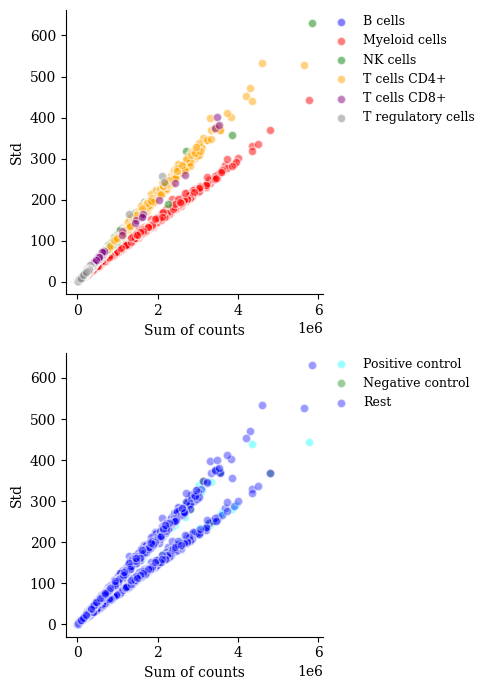

In [5]:
xs = sum_count
ys = np.std(np.abs(bulk_adata_df), axis=1)
plot_scatter(bulk_adata_df, obs_index, xs, ys, x_label='Sum of counts', y_label='Std', log=False, log_y=False)



### Sum of counts vs cell count

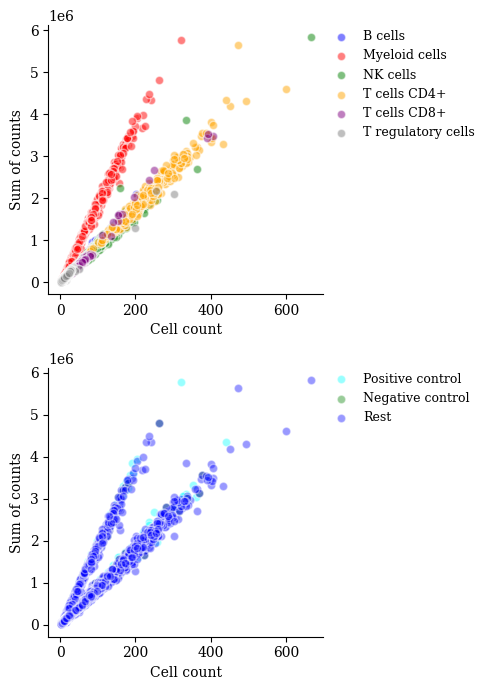

In [6]:
xs = cell_count
ys = sum_count
fig, axes = plot_scatter(bulk_adata_df, obs_index, xs, ys, x_label='Cell count', y_label='Sum of counts', log=False, log_y=False)

# fig.savefig(f'{work_dir}/preprocess/figs/eda1_cellcount_sumcounts_raw.png', dpi=150, transparent=True)

## Number of psuedobulked samples 

In [8]:
sample_n = bulk_adata.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.loc[:, train_cell_types] = sample_n.loc[:, train_cell_types].fillna(0) # fill nans and sort for train cell type

sample_n['total'] = sample_n[train_cell_types].sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells,total
sm_name,,,,,,,
GW843682X,3,3,3,3,3,3,12
HMN-214,3,3,3,3,3,3,12
Belinostat,48,48,48,48,12,19,127
Dimethyl Sulfoxide,48,48,48,48,48,48,192
Dabrafenib,48,48,48,48,48,48,192


144


(<Figure size 2500x400 with 1 Axes>,
 <Axes: title={'center': 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples'}>)

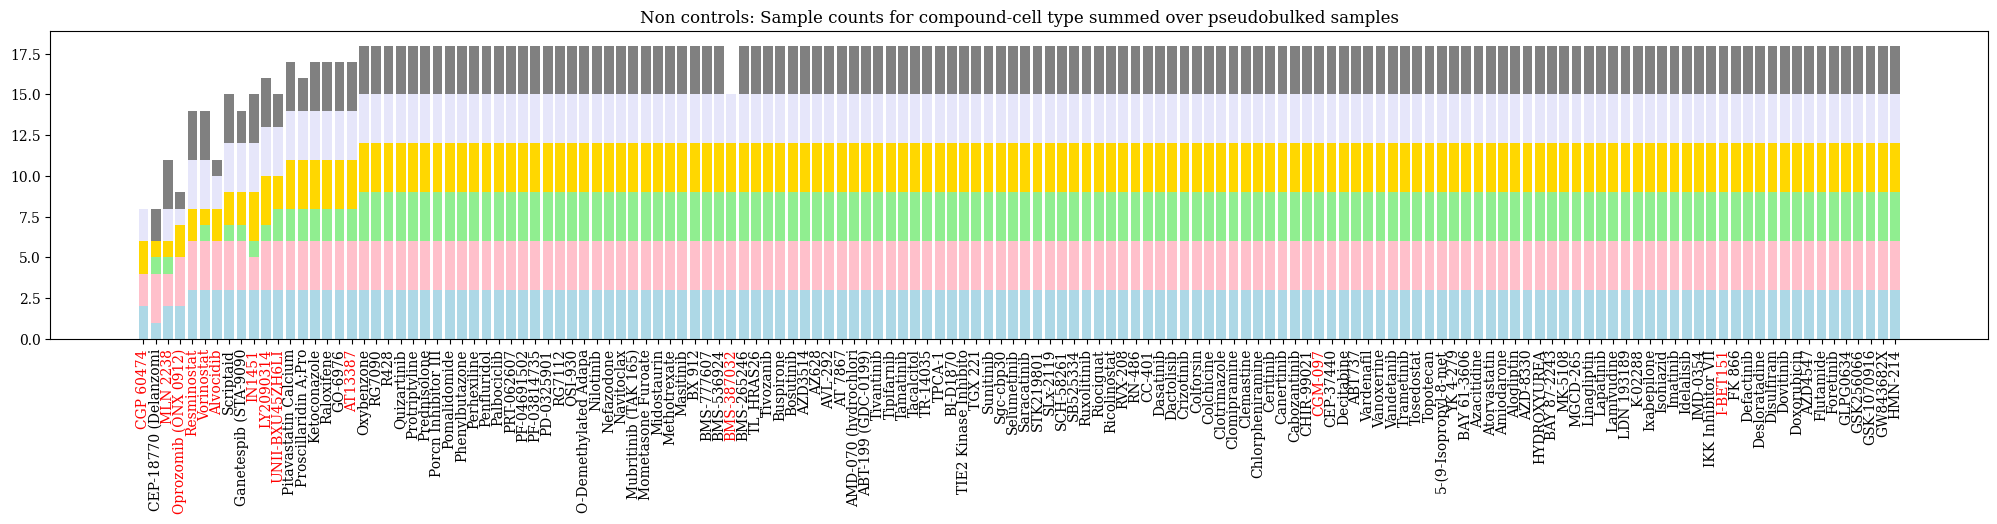

In [9]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    if sm_name in outliers_me:
        colors.append('red')
    else:
        colors.append('black')

plot_stacked_bar_chart(cc[cell_types], 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))

3


(<Figure size 500x250 with 1 Axes>,
 <Axes: title={'center': 'Controls: sample counts for compound-cell type summed over pseudobulked samples'}>)

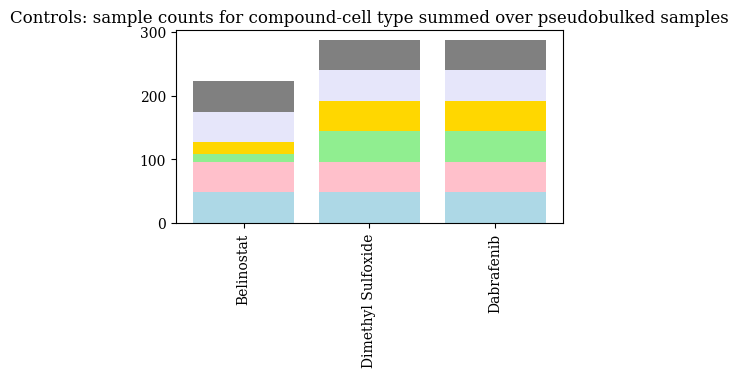

In [11]:
# Plot for non controls
cc = sample_n.loc[sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    colors.append('black')

plot_stacked_bar_chart(cc[cell_types], 'Controls: sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(5, 2.5))

## Ratio of cell counts for different cell types

In [12]:
cell_count = bulk_adata.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].sum())

In [13]:
ratio_celltypes = cell_count.reset_index().drop(columns='sm_name').groupby('cell_type').sum().reset_index()
ratio_celltypes = ratio_celltypes[ratio_celltypes.cell_type.isin(train_cell_types)].set_index('cell_type').to_dict()[0]

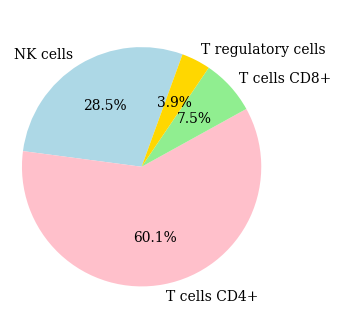

In [14]:
fig, ax = plt.subplots(1,1 , figsize=(3.5, 3.5))  # Adjust the figure size as needed

ax.pie(ratio_celltypes.values(), labels=ratio_celltypes.keys(), autopct='%1.1f%%', startangle=70, colors=colors_cell_type)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios.png', dpi=100, transparent=True)
plt.show()

## Potential misclassification of cell types + low cell count

In [15]:
cell_count_m = cell_count.unstack('cell_type') # shape (n_compounds, n_cell_types) matrix
if False:
cell_count_m.loc[:, train_cell_types] = cell_count_m.loc[:, train_cell_types].fillna(0) # fill nans and sort for train cell type

cell_count_m['total'] = cell_count_m[train_cell_types].sum(axis=1) # Sort by the number of cells of the four training cell types
cell_count_m.sort_values('total', inplace=True)


In [16]:
len(outliers_me)

16

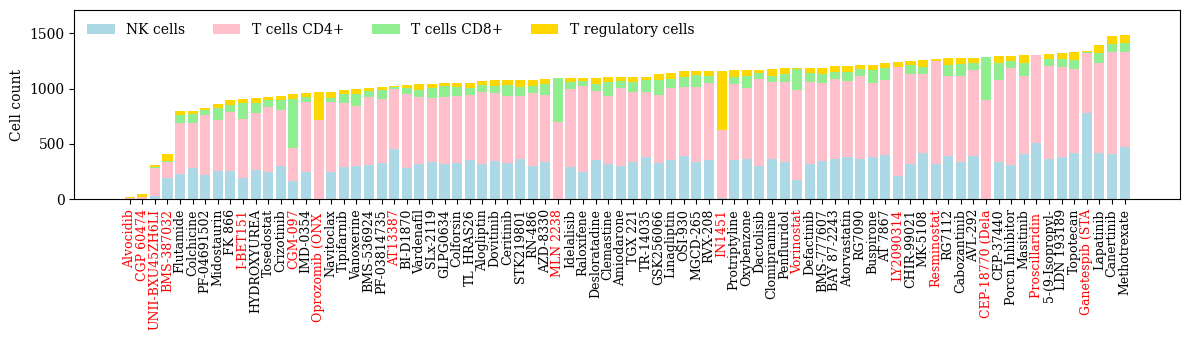

In [17]:
# Plot for non controls
cc = cell_count_m.loc[~cell_count_m.index.isin(controls3),:]

if True: # dont show all the compounds 
    outliers_df = cc.loc[cc.index.isin(outliers_me)]
    remaining_sm_names = cc.index.difference(outliers_df.index)
    sampled_remaining = cc.loc[remaining_sm_names].sample(frac=0.5, random_state=42)
    cc = pd.concat([outliers_df, sampled_remaining])
    cc = cc.sort_values('total')

sorted_compound_names = cc.index
xticks = np.arange(len(cc))
xticklabels = sorted_compound_names
xticklabels_short = [label[0:20] for label in xticklabels]


colors = []
if False: # only show outliers
    xticklabels_new = []
    for label in xticklabels:
        if label in outliers_me:
            xticklabels_new.append(label)
        else:
            xticklabels_new.append('')
        colors.append('red')
    xticklabels = xticklabels_new  
else:
    for i, sm_name in enumerate(xticklabels):
        if sm_name in outliers_me:
            colors.append('red')
        else:
            colors.append('black')

xticklabels_short = [label[0:15] for label in xticklabels]

fig, ax = plot_stacked_bar_chart(cc[train_cell_types], '', xticks=xticks, xticklabels=xticklabels_short, colors=colors, figsize=(12,3.5))
ax.set_ylabel('Cell count')
# ax.add_artist(first_legend)
x_min, x_max = ax.get_ylim()
x_margin = 0.1 * (x_max - x_min)
ax.set_ylim(x_min, x_max + x_margin)

x_min, x_max = ax.get_xlim()
x_margin = 0 * (x_max - x_min)
ax.set_xlim(x_min, x_max - x_margin)
# ax.legend(title='Cell types', loc='left', bbox_to_anchor=(1, 0.5))
ax.legend(ncol=4, frameon=False, loc='upper left')
plt.xticks(fontsize=9)
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/ambros_style_graph.png', dpi=100)


## Missing counts

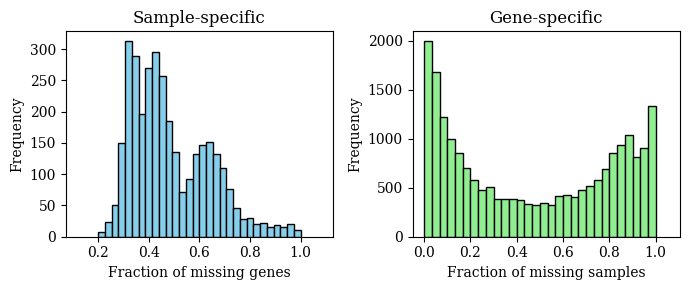

In [18]:
# Calculate sparsity for observations (samples)
obs_sparsity = (bulk_adata.X == 0).sum(axis=1)
obs_sparsity = obs_sparsity/obs_sparsity.max()
# Calculate sparsity for variables (genes)
var_sparsity = (bulk_adata.X == 0).sum(axis=0)
var_sparsity = var_sparsity/ var_sparsity.max()

# Plot histograms for observations and variables
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# Plot histogram for observation-specific sparsity
ax = axs[0]
ax.hist(obs_sparsity, bins=30, color='skyblue', edgecolor='black')
ax.set_title('Sample-specific')
ax.set_xlabel('Fraction of missing genes')
ax.set_ylabel('Frequency')
x_min, x_max = ax.get_xlim()
x_margin = 0.1 * (x_max - x_min)
ax.set_xlim(x_min-x_margin, x_max + x_margin)

# Plot histogram for variable-specific sparsity
ax = axs[1]
ax.hist(var_sparsity, bins=30, color='lightgreen', edgecolor='black')
ax.set_title('Gene-specific')
ax.set_xlabel('Fraction of missing samples')
ax.set_ylabel('Frequency')
x_min, x_max = ax.get_xlim()
x_margin = 0.05 * (x_max - x_min)
ax.set_xlim(x_min, x_max + x_margin)

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)
plt.show()


(<Figure size 500x700 with 2 Axes>,
 array([<Axes: xlabel='Sum of counts', ylabel='Non missing counts'>,
        <Axes: xlabel='Sum of counts', ylabel='Non missing counts'>],
       dtype=object))

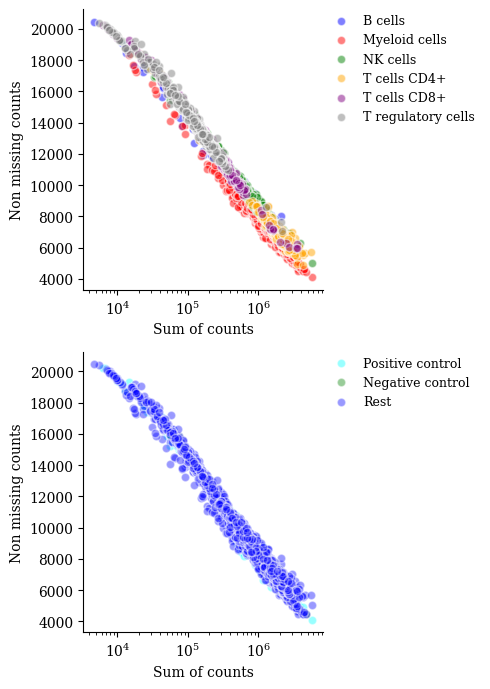

In [19]:
xs = sum_count
ys = missing_count

plot_scatter(bulk_adata_df, obs_index, xs, ys, x_label='Sum of counts', y_label='Non missing counts', log=True)


In [20]:
bulk_adata_df.columns.shape

(21265,)

In [21]:
non_missing_count.sum()/bulk_adata_df.size

0.5313173311430597

# Filtering

In [22]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata.h5ad')
print(bulk_adata)
assert (bulk_adata.shape[1]==18211)

AnnData object with n_obs × n_vars = 2558 × 18211
    obs: 'col', 'library_id', 'donor_id', 'sm_name', 'dose_uM', 'cell_type', 'timepoint_hr', 'control', 'sm_lincs_id', 'well', 'plate_name', 'SMILES', 'cell_id', 'row', 'cell_count', 'positive_control', 'negative_control'
    var: 'gene'


### <a id='toc5_4_1_'></a>[Filtering genes with edgeR](#toc0_)

In [23]:
%%R -i work_dir -o filtered_data_edgR 
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)
adata_de = readH5AD(paste0(work_dir, '/preprocess/bulk_adata.h5ad'))

filter_func <- function(adata_){
    d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name, genes=rowData(adata_)$gene)
    print("Dimensions before subsetting:")
    print(dim(d))
    keep <- filterByExpr(d)
    d <- d[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(d))
    return (d)
}
filtered_data_edgR <-filter_func(adata_de)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [1] "Dimensions before subsetting:"
[1] 18211  2558
[1] "Dimensions after subsetting:"
[1] 12097  2558


Loading required package: limma
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2

12004


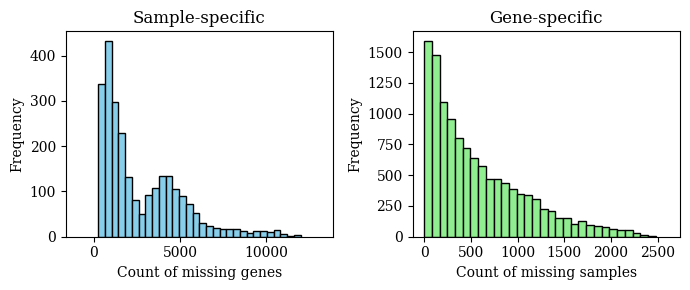

In [24]:
filtered_df_edger = pd.DataFrame(filtered_data_edgR['counts'].T, columns=filtered_data_edgR['genes'].genes.values)
# Calculate sparsity for observations (samples)
obs_sparsity = (filtered_df_edger == 0).sum(axis=1)
print(max(obs_sparsity))
# Calculate sparsity for variables (genes)
var_sparsity = (filtered_df_edger == 0).sum(axis=0)

# Plot histograms for observations and variables
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# Plot histogram for observation-specific sparsity
ax = axs[0]
ax.hist(obs_sparsity, bins=30, color='skyblue', edgecolor='black')
ax.set_title('Sample-specific')
ax.set_xlabel('Count of missing genes')
ax.set_ylabel('Frequency')
x_min, x_max = ax.get_xlim()
x_margin = 0.1 * (x_max - x_min)
ax.set_xlim(x_min-x_margin, x_max + x_margin)

# Plot histogram for variable-specific sparsity
ax = axs[1]
ax.hist(var_sparsity, bins=30, color='lightgreen', edgecolor='black')
ax.set_title('Gene-specific')
ax.set_xlabel('Count of missing samples')
ax.set_ylabel('Frequency')
x_min, x_max = ax.get_xlim()
x_margin = 0.05 * (x_max - x_min)
ax.set_xlim(x_min, x_max + x_margin)

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)
plt.show()


In [25]:
# genes suggested by figr
genes_edger = filtered_df_edger.columns
mask_genes_edger = bulk_adata.var.isin(genes_edger).gene

### <a id='toc5_4_2_'></a>[Genes with low samples](#toc0_)

In [26]:
# extra filtering on genes 
min_sample = 500
mask_genes_min_sample = (bulk_adata.X!=0).sum(axis=0)>=min_sample

### <a id='toc5_4_3_'></a>[Outlier compounds identified previously](#toc0_)

In [27]:
mask_samples_outliers_compounds = ~bulk_adata.obs.sm_name.isin(outliers_me)

### <a id='toc5_4_4_'></a>[Samples with low cell count](#toc0_)

In [28]:
mask_samples_cell_count = bulk_adata.obs['cell_count']>10

### <a id='toc5_4_5_'></a>[Samples with low gene coverage](#toc0_)

In [29]:
sum_samp = (bulk_adata.X!=0).sum(axis=1)
mask_samples_low_gene = (sum_samp>4000)

### <a id='toc5_4_6_'></a>[All together](#toc0_)

In [30]:
mask_samples_cell_count.shape

(2558,)

In [31]:
mask_genes = mask_genes_edger * mask_genes_min_sample
mask_samples = mask_samples_cell_count * mask_samples_outliers_compounds * mask_samples_low_gene

bulk_adata_f = bulk_adata[mask_samples, mask_genes]
bulk_adata_f.shape

(2197, 11930)

In [32]:
bulk_adata_f.obs.reset_index(drop=True, inplace=True)
bulk_adata_f.var.reset_index(drop=True, inplace=True)

In [33]:
# save filtered adata
bulk_adata_f.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

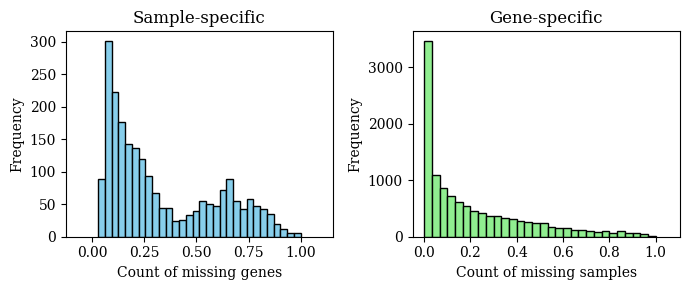

In [34]:
# Calculate sparsity for observations (samples)
obs_sparsity = (bulk_adata_f.X == 0).sum(axis=1)
obs_sparsity = obs_sparsity/obs_sparsity.max()
# Calculate sparsity for variables (genes)
var_sparsity = (bulk_adata_f.X == 0).sum(axis=0)
var_sparsity = var_sparsity/ var_sparsity.max()
# Plot histograms for observations and variables
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# Plot histogram for observation-specific sparsity
ax = axs[0]
ax.hist(obs_sparsity, bins=30, color='skyblue', edgecolor='black')
ax.set_title('Sample-specific')
ax.set_xlabel('Count of missing genes')
ax.set_ylabel('Frequency')
x_min, x_max = ax.get_xlim()
x_margin = 0.1 * (x_max - x_min)
ax.set_xlim(x_min-x_margin, x_max + x_margin)

# Plot histogram for variable-specific sparsity
ax = axs[1]
ax.hist(var_sparsity, bins=30, color='lightgreen', edgecolor='black')
ax.set_title('Gene-specific')
ax.set_xlabel('Count of missing samples')
ax.set_ylabel('Frequency')
x_min, x_max = ax.get_xlim()
x_margin = 0.05 * (x_max - x_min)
ax.set_xlim(x_min, x_max + x_margin)

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)
plt.show()

# EDA after filtering

In [35]:
bulk_adata_f = ad.read(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

## Distribution of pseudobulkd samples 

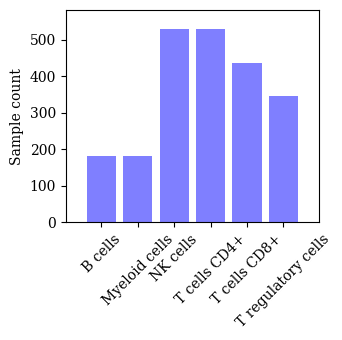

In [36]:
samples_counts = bulk_adata_f.obs.groupby('cell_type').size().to_dict()

fig, ax = plt.subplots(1,1 , figsize=(3.5, 3.5))  # Adjust the figure size as needed
ax.bar(samples_counts.keys(), samples_counts.values(), color='blue', alpha=0.5)
ax.set_ylabel('Sample count')
ax.margins(0.1)
plt.tick_params('x', rotation=45)
plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios.png', dpi=100, transparent=True)
plt.show()

In [37]:
samples_counts

{'B cells': 180,
 'Myeloid cells': 180,
 'NK cells': 528,
 'T cells CD4+': 528,
 'T cells CD8+': 435,
 'T regulatory cells': 346}

## Distribution of pseudobulkd samples per compound

In [38]:
sample_n = bulk_adata_f.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.loc[:, train_cell_types] = sample_n.loc[:, train_cell_types].fillna(0) # fill nans and sort for train cell type

sample_n['total'] = sample_n[train_cell_types].sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells,total
sm_name,,,,,,,
Tivozanib,0,0,3,3,3,3,12
Tivantinib,0,0,3,3,3,3,12
Belinostat,48,48,48,48,8,1,105
Dabrafenib,48,48,48,48,44,33,173
Dimethyl Sulfoxide,48,48,48,48,43,40,179


128


(<Figure size 2500x400 with 1 Axes>,
 <Axes: title={'center': 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples'}>)

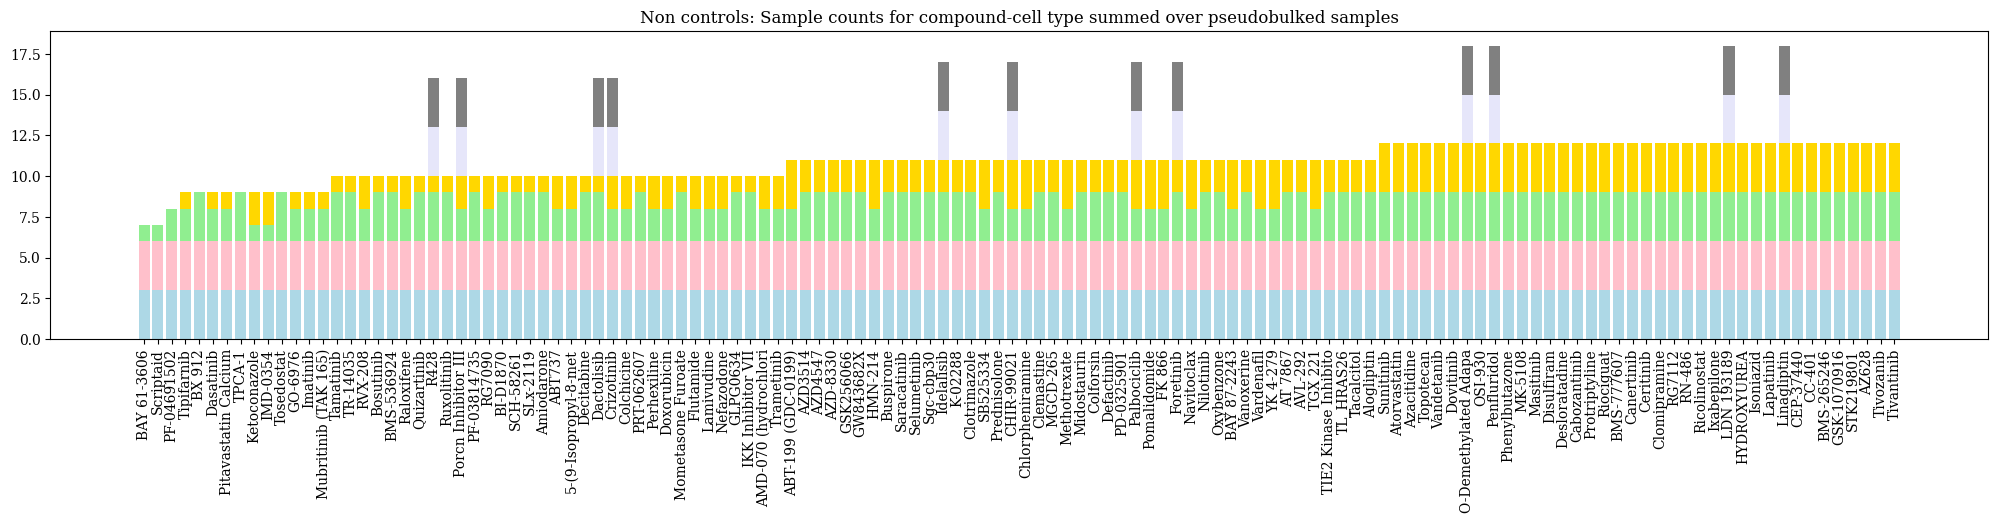

In [39]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    if sm_name in outliers_me:
        colors.append('red')
    else:
        colors.append('black')

plot_stacked_bar_chart(cc[cell_types], 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))

# Normalize

In [40]:
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
bulk_adata_f.layers['counts'] = bulk_adata_f.X

In [41]:
assert (bulk_adata_f.X.flatten()==0).sum()/bulk_adata_f.X.flatten().size>0
# assert type(bulk_adata_f.X.flatten()[0])==int

In [42]:
bulk_adata_f.X

array([[ 9,  3,  6, ...,  0,  0,  0],
       [35,  7, 21, ...,  6,  0,  0],
       [ 3,  0,  0, ...,  0,  0,  0],
       ...,
       [47,  7, 27, ...,  0,  0,  0],
       [ 9,  0,  4, ...,  0,  0,  0],
       [ 8,  1,  4, ...,  0,  0,  1]], dtype=uint32)

## Library size normalization 

In [43]:

def custom_normalize(adata):
    adata.obs['total_counts'] = adata.X.sum(axis=1)
    library_sums = adata.obs.groupby('library_id')['total_counts'].transform('sum').values.reshape(-1, 1)
    size = adata.obs.groupby('library_id').transform('size').values.reshape(-1, 1)
    adata.X = ((adata.X) / (library_sums/size)) * (1e6/np.mean(size))

adata = bulk_adata_f.copy()

custom_normalize(adata)
# # if True:
# #     sc.pp.log1p(adata)
#     # sce.pp.magic(adata, knn=20, n_pca=20, solver='exact')
#     # sc.pp.scale(adata)
adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f_n_custom.h5ad')

## Scanpy shifted algorithm

In [44]:
from sklearn.impute import KNNImputer
def knn_imputer(adata):
    imputer = KNNImputer(n_neighbors=10)
    data = adata.X
    mask = data==0
    data[mask] = np.nan
    adata.X = imputer.fit_transform(data)

adata = bulk_adata_f.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata)
# print(adata.var.highly_variable.sum())
# if True:
    
#     knn_imputer(adata)
    # sce.pp.magic(adata, knn=20, n_pca=20, solver='exact')
    # sc.pp.log1p(adata)
    # sc.pp.scale(adata)

    # sc.pp.highly_variable_genes(adata)
    # print('HVGs', adata.var.highly_variable.sum())
adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f_n_shifted_algorithm.h5ad')

In [45]:
(adata.X.flatten()==0).sum()/adata.X.flatten().size

0.16930196286103774

In [46]:
if False:
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var.highly_variable]
    print('HVGs', adata.var.highly_variable.sum())

## Scanpy pearson residuals
The third normalization technique we are introducing in this chapter is the analytic approximation of Pearson residuals. This normalization technique was motivated by the observation that cell-to-cell variation in scRNA-seq data might be confounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from ‘regularized negative binomial regression’ to calculate a model of technical noise in the data. 

In [47]:

adata = bulk_adata_f.copy()
sc.experimental.pp.normalize_pearson_residuals(adata)
adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f_n_pearson.h5ad')


# EDA on normalized data

In [48]:
norm_tag = 'n_shifted_algorithm' # n_shifted_algorithm, n_pearson
adata_n = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f_{norm_tag}.h5ad')
obs_index = ['cell_type','sm_name']
adata_index = ['sm_name', 'cell_type', 'plate_name', 'row', 'library_id']

adata = adata_n.copy()

adata_df = pd.DataFrame(adata.X, index= pd.MultiIndex.from_frame(adata.obs[adata_index]))
sum_count = adata_df.sum(axis=1)
cell_count = adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(adata_df)
non_missing_count = (adata_df!=0).sum(axis=1)
top_quantile = (adata_df>adata_df.quantile(.95, axis=0)).sum(axis=1)/adata_df.shape[1]

if False:
    std = np.std(np.abs(adata_df), axis=1)
else:
    std = []
    for index, row in adata_df.iterrows():
        std.append(np.std(row[row!=0]))
    std = pd.DataFrame(std, index=adata_df.index)
print('sparsity', (adata.X.flatten()==0).sum()/adata.X.flatten().size)

sparsity 0.16930196286103774


## Normality

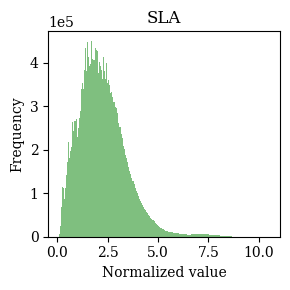

In [49]:
import matplotlib.pyplot as plt

# Define colors
color = 'green'

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=False)

# Plot histogram
data = adata.X.flatten()
data = data[data!=0]
ax.hist(data, bins=200, color=color, alpha=.5)

# Set axis labels and title
ax.set_xlabel('Normalized value')
ax.set_ylabel('Frequency')
if norm_tag == 'n_pearson':
    ax.set_xlim([-11,11])
    title = 'APR'
elif norm_tag == 'n_shifted_algorithm':
    title = 'SLA'
ax.ticklabel_format(axis='y', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_yscale('log')
# Add margin to the plot
# ax.margins(0.05)
ax.set_title(title)
plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/norm_values_hist_{norm_tag}.png', dpi=100)
# Show plot
# plt.show()



## Std

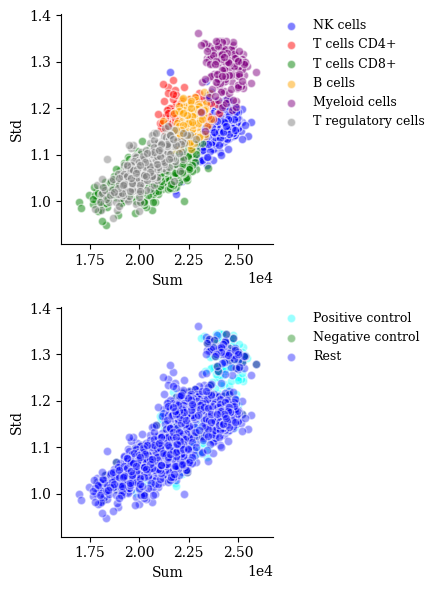

In [50]:
xs = sum_count
ys = std

fig, axes = plot_scatter(adata_df, obs_index, xs, ys, x_label='Sum', y_label='Std', log=False, figsize=(4.5,6))
for ax in axes:
    ax.margins(0.1)
    ax.ticklabel_format(axis='x', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/std_sum_nomalized_{norm_tag}.png', dpi=100)

## Top quantile 

(<Figure size 500x700 with 2 Axes>,
 array([<Axes: xlabel='Count sum', ylabel='Ratio of top quantile (0.95)'>,
        <Axes: xlabel='Count sum', ylabel='Ratio of top quantile (0.95)'>],
       dtype=object))

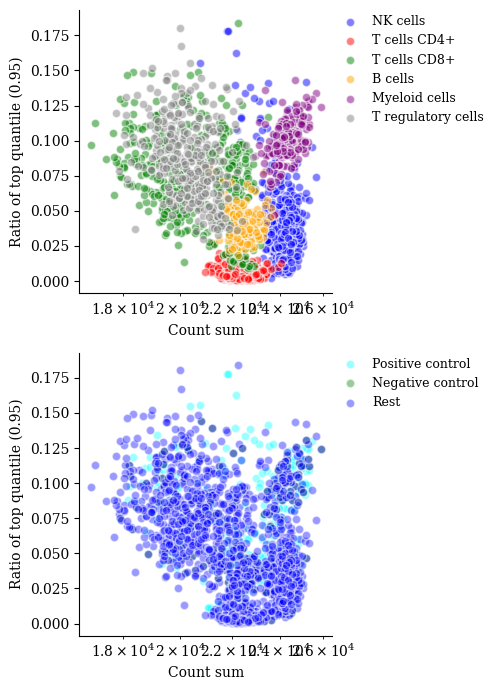

In [51]:
ys = top_quantile
xs = sum_count

plot_scatter(adata_df, obs_index, xs, ys, x_label='Count sum', y_label='Ratio of top quantile (0.95)', log=True)

## Clusters

In [52]:
adata_n_c = adata_n.copy()
with warnings.catch_warnings():
    sc.tl.pca(adata_n_c, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata_n_c, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata_n_c)

In [53]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata_n_c.obs['Donor'] = adata_n_c.obs.donor_id.map(map_names)
adata_n_c.obs['Cell type'] = adata_n_c.obs.cell_type

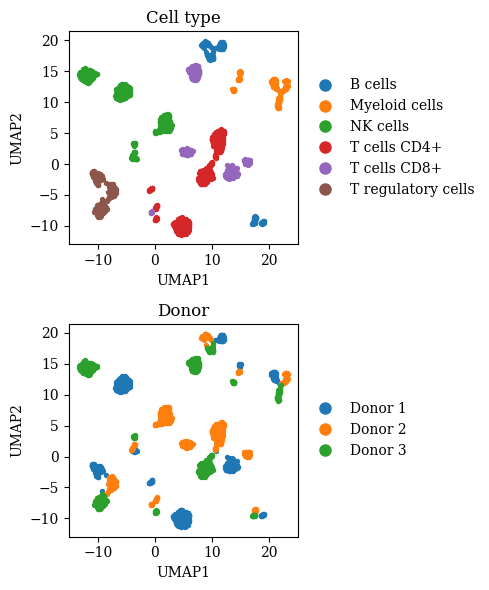

In [54]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

def cluster_plot(adata, var, ax):
    dim_data = adata.obsm['X_umap']
    legend_handles = []  
    var_unique = sorted(adata.obs[var].unique())  
    var_unique_sorted = sorted(var_unique)  
    for sub_var in var_unique_sorted:
        mask = adata.obs[var] == sub_var
        sub_data = dim_data[mask]
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=8)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

    ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(var)

for i_ax, var in enumerate(['Cell type', 'Donor']): 
    cluster_plot(adata_n_c, var, axes[i_ax])

plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/normalized_cluster_{norm_tag}.png', dpi=150, transparent=True)
plt.show()

In [55]:
aa 

NameError: name 'aa' is not defined

# DE analysis using EdgeR

In [ ]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/adata_f_hdgs.h5ad')
adata_de = bulk_adata.copy()
adata_de

AnnData object with n_obs × n_vars = 2197 × 4000
    obs: 'timepoint_hr', 'plate_name', 'library_id', 'sm_name', 'donor_id', 'SMILES', 'col', 'cell_id', 'sm_lincs_id', 'control', 'row', 'well', 'dose_uM', 'cell_type', 'cell_count', 'positive_control', 'negative_control'
    var: 'gene'

### <a id='toc6_1_1_'></a>[Format adata](#toc0_)

In [ ]:
compound_name_col = 'sm_name'

#  limma doesn't like dashes etc. in the names
# sm_name
unique_sm_name = adata_de.obs.sm_name.unique()
sm_name_map = {sm_name:f'sm_name_{number}' for sm_name, number in zip(unique_sm_name, range(len(unique_sm_name)))}
sm_name_s_map = {value: key for key, value in sm_name_map.items()}
# cell type
unique_cell_type = adata_de.obs.cell_type.unique()
cell_type_map = {cell_type:f'celltype_{number}' for cell_type, number in zip(unique_cell_type, range(len(unique_cell_type)))}
cell_type_s_map = {value: key for key, value in cell_type_map.items()}
adata_de.obs['sm_name_s'] = adata_de.obs['sm_name'].map(sm_name_map).astype(str)
adata_de.obs['cell_type_s'] = adata_de.obs['cell_type'].map(cell_type_map)
negative_control_s = sm_name_map[negative_control] 

adata_de.var = adata_de.var.reset_index()

adata_de.shape

(2197, 4000)

## Voom and lmfit

In [ ]:
%%time
%%R -i main_dir -i negative_control_s -o topGenesList
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)

adata_de = readH5AD(paste0(main_dir, "/output/preprocess/adata_de.h5ad"))

adata_ <- adata_de
d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s, genes=rowData(adata_)$gene, samples=colData(adata_)$sm_name_s)
print("Dimensions before subsetting:")
print(dim(d))
d <- calcNormFactors(d)
group <- paste0(colData(adata_)$sm_name_s, ".", colData(adata_)$cell_type_s)
# group <- colData(adata_)$sm_name_s
plate_name <- colData(adata_)$plate_name
row <- colData(adata_)$row
design <- model.matrix(~ 0 + group + plate_name + row)
print("Dimensions of design matrix:")
print(dim(design))
y <- voom(d, design, plot=TRUE)

vfit <- lmFit(y, design) 


topGenesList <- list()
for(compound in unique(colData(adata_de)$sm_name_s)) {
  for(celltype in unique(colData(adata_de)$cell_type_s)) {
    treatment = sprintf("group%s.%s", compound, celltype)
    ctr = sprintf("group%s.%s", negative_control_s, celltype)
    if (!(treatment %in% colnames(design))){
      print(sprintf("%s doesnt exists", treatment))
    }
    else if ((treatment == ctr)){
      print("pass")
    }
    else{
    print(sprintf("%s running", treatment))
    contrast_name <- sprintf("%s - %s", treatment, ctr)
    # Create the contrast matrix
    contrastMatrix <- makeContrasts(contrasts=contrast_name, levels=design)
    
    fit2 <- contrasts.fit(vfit, contrastMatrix)
    fit2 <- eBayes(fit2)
    
    topGenes <- topTable(fit2, adjust="fdr", sort.by="P", number=Inf)
    topGenesList[[paste(compound, celltype, sep=".")]] <- topGenes
    }
  }
}

/root/.cache/R/basilisk/1.14.3/zellkonverter/1.12.1/zellkonverterAnnDataEnv-0.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[1] "Dimensions before subsetting:"
[1] 10750  2197
[1] "Dimensions of design matrix:"
[1] 2197  560


In [ ]:
df_de_stack = []
for key, df in topGenesList.items():
    sm_name_s, cell_type_s = key.split('.')
    sm_name = sm_name_s_map[sm_name_s]
    cell_type = cell_type_s_map[cell_type_s]
    df.sort_values('genes', inplace=True)
    
    df['sm_name'] = sm_name
    df['cell_type'] = cell_type

    df = df.set_index(['sm_name', 'cell_type'])
    df_de_stack.append(df)

In [ ]:
df_de = pd.concat(df_de_stack, axis=0)
df_de['sign_log10_pval'] = np.sign(df_de['logFC']) * -np.log10(df_de['adj.P.Val'])

In [ ]:
de_train_t = df_de.pivot(columns='genes', values='t')
de_train_t.columns.name = None
de_train = df_de.pivot(columns='genes', values='sign_log10_pval')
de_train.columns.name = None
de_train_p = df_de.pivot(columns='genes', values='adj.P.Val')
de_train_p.columns.name = None

### <a id='toc6_2_1_'></a>[Save](#toc0_)

In [ ]:
de_train_t.to_parquet(f'{out_edger_dir}/de_train_t.parquet')
de_train.to_parquet(f'{out_edger_dir}/de_train.parquet')
de_train_p.to_parquet(f'{out_edger_dir}/de_train_p.parquet')

## 

In [ ]:
%%R -i main_dir
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)
library("BiocParallel")
register(MulticoreParam(10))

adata = readH5AD(paste0(main_dir, "output/preprocess/adata_de_hdgs.h5ad"))

fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s)
    print("Dimensions: ")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    sm_name <- paste0(colData(adata_)$sm_name_s)
    plate_name <- colData(adata_)$plate_name
    row <- colData(adata_)$row
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + sm_name + plate_name + row)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}
# vsd_dict = list()
# # for (cell_type_s in unique(adata@colData$cell_type_s)){
cell_type_s = "celltype_2"
# # for (cell_type_s in c("celltype_2", "celltype_3")){
print(cell_type_s)
mask = colData(adata)$cell_type_s==cell_type_s
adata_subset = adata[,mask]
fit_model(adata_subset)
# }


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [1] "celltype_2"
[1] "Dimensions: "
[1] 4000  435
[1] ""


In [ ]:
%%R 
plotBCV(y)


In [ ]:
%%R -o tt
myContrast <- makeContrasts('groupstim.CD14_Monocytes-groupctrl.CD14_Monocytes', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [ ]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

# <a id='toc7_'></a>[DE analysis limma](#toc0_)

In [ ]:
import limma_utils
from dask import delayed
from dask.distributed import Client, LocalCluster

de_pert_cols = [
    'sm_name',
    'sm_lincs_id',
    'SMILES',
    'dose_uM',
    'timepoint_hr',
    'cell_type',
]
os.makedirs(out_limma_dir, exist_ok=True)
def _run_limma_for_cell_type(bulk_adata):
    bulk_adata = bulk_adata.copy()
    compound_name_col = de_pert_cols[0]
    # limma doesn't like dashes etc. in the compound names
    rpert_mapping = bulk_adata.obs[compound_name_col].drop_duplicates() \
        .reset_index(drop=True).reset_index() \
        .set_index(compound_name_col)['index'].to_dict()
    
    bulk_adata.obs['Rpert'] = bulk_adata.obs.apply(
        lambda row: rpert_mapping[row[compound_name_col]], 
        axis='columns',
    ).astype('str')

    compound_name_to_Rpert = bulk_adata.obs.set_index(compound_name_col)['Rpert'].to_dict()
    ref_pert = compound_name_to_Rpert[negative_control]
            
    random_string = binascii.b2a_hex(os.urandom(15)).decode()
    
    limma_utils.limma_fit(
        bulk_adata, 
        design='~0+Rpert+plate_name+row',
        output_path=f'{out_limma_dir}/{random_string}_limma.rds',
        plot_output_path=f'{out_limma_dir}/{random_string}_voom',
        exec_path='limma_fit.r',
    )

    pert_de_dfs = []
    for pert in bulk_adata.obs['Rpert'].unique():
        if pert == ref_pert:
            continue

        pert_de_df = limma_utils.limma_contrast(
            fit_path=f'{out_limma_dir}/{random_string}_limma.rds',
            contrast='Rpert'+pert+'-Rpert'+ref_pert,
            exec_path='limma_contrast.r',
        )

        pert_de_df['Rpert'] = pert

        pert_obs = bulk_adata.obs[bulk_adata.obs['Rpert'].eq(pert)]
        for col in de_pert_cols:
            pert_de_df[col] = pert_obs[col].unique()[0]
        pert_de_dfs.append(pert_de_df)
    de_df = pd.concat(pert_de_dfs, axis=0)
    try:
        os.remove(f'{out_limma_dir}/{random_string}_limma.rds')
        os.remove(f'{out_limma_dir}/{random_string}_voom')
    except FileNotFoundError:
        pass
    return de_df
run_limma_for_cell_type = delayed(_run_limma_for_cell_type)
cluster = LocalCluster(
    n_workers=6, 
    processes=True,
    threads_per_worker=1,
    memory_limit='20GB',
)
c = Client(cluster)

In [ ]:
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
bulk_adata_f.var = bulk_adata_f.var.set_index('gene')

cell_types = bulk_adata_f.obs['cell_type'].unique()
de_dfs = []

for cell_type in cell_types:
    cell_type_selection = bulk_adata_f.obs['cell_type'].eq(cell_type)
    cell_type_bulk_adata = bulk_adata_f[cell_type_selection].copy()
    
    de_df = run_limma_for_cell_type(cell_type_bulk_adata)
    
    de_dfs.append(de_df)

de_dfs = c.compute(de_dfs, sync=True)
de_df = pd.concat(de_dfs)

In [ ]:
de_sig_cutoff = 0.05
de_df_copy = de_df.copy()
zero_pval_selection = de_df_copy['P.Value'].eq(0)
de_df_copy.loc[zero_pval_selection, 'P.Value'] = np.finfo(np.float64).eps

de_df_copy['sign_log10_pval'] = np.sign(de_df_copy['logFC']) * -np.log10(de_df_copy['P.Value'])
de_df_copy['is_de'] = de_df_copy['P.Value'].lt(de_sig_cutoff)
de_df_copy['is_de_adj'] = de_df_copy['adj.P.Val'].lt(de_sig_cutoff)

In [ ]:
de_train = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='sign_log10_pval') 
de_train_t = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='t')
de_train_p = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='adj.P.Val')

In [ ]:
de_train_t.to_parquet(f'{out_limma_dir}/de_train_t.parquet')
de_train_p.to_parquet(f'{out_limma_dir}/de_train_p.parquet')
de_train.to_parquet(f'{out_limma_dir}/de_train.parquet')

# <a id='toc8_'></a>[EDA on de results](#toc0_)

In [ ]:
if False: #edgeR
    de_train_t = pd.read_parquet(f'{out_edger_dir}/de_train_t.parquet')
    de_train_p = pd.read_parquet(f'{out_edger_dir}/de_train_p.parquet')

elif True: #limma 
    de_train_t = pd.read_parquet(f'{out_limma_dir}/de_train_t.parquet')
    de_train_p = pd.read_parquet(f'{out_limma_dir}/de_train_p.parquet')

bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
adata_df = pd.DataFrame(bulk_adata_f.X, index= pd.MultiIndex.from_frame(bulk_adata_f.obs[bulk_index]), columns=bulk_adata_f.var.gene )

cell_count = bulk_adata_f.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].sum()).reindex_like(de_train_t)
std = np.std(de_train_t , axis=1)
plus_values = np.mean(de_train_t.values>0 , axis=1)
sig_values = np.mean(de_train_p < 0.05, axis=1)
sample_n = bulk_adata_f.obs.groupby(['sm_name', 'cell_type']).size().reindex_like(de_train_t)
sum_count_genes = adata_df.groupby(['sm_name', 'cell_type']).sum().reindex_like(de_train_t)
sum_count = adata_df.groupby(['sm_name', 'cell_type']).sum().reindex_like(de_train_t).sum(axis=1)
obs_index = ['cell_type', 'sm_name']

## Plot MA

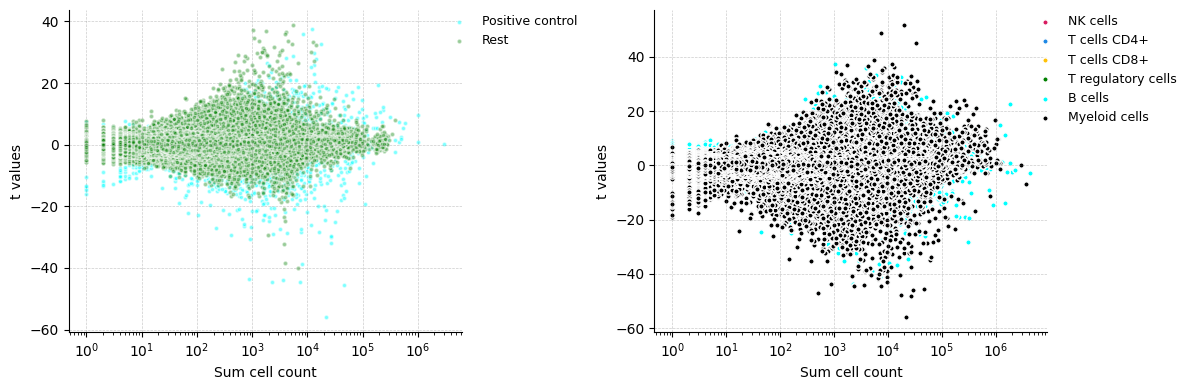

In [ ]:
colors = [
    "#D81B60",  # Vivid pink
    "#1E88E5",  # Bright blue
    "#FFC107",  # Amber
    "green",  # Deep teal
    "cyan",  # Yellow
    "black",  # Deep purple
]
def plotMA(df_x, df_y, obs_index, x_label='', y_label='', log=True):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
    for i_index, index in enumerate(obs_index):
        i = i_index // 2
        j = i_index % 2
        ax = axes[j]
        index_vars = df_x.index.get_level_values(index)
        if index=='sm_name':
            mask = (index_vars.isin(controls2))
            
            xs = df_x.loc[mask,:].values.flatten()
            ys = df_y.loc[mask,:].values.flatten() 
            sparse_mask = np.random.choice([True, False], len(xs), p=[.1,.9])
            ax.scatter(xs[sparse_mask], ys[sparse_mask], label='Positive control', alpha=0.5, color='cyan', edgecolors='white', s=10)

            xs = df_x.loc[~mask,:].values.flatten()
            ys = df_y.loc[~mask,:].values.flatten() 
            sparse_mask = np.random.choice([True, False], len(xs), p=[1,0])
            ax.scatter(xs[sparse_mask], ys[sparse_mask], label='Rest', alpha=0.4, color='green', edgecolors='white', s=10)
        else:
            included_vars = index_vars.unique()
            for i, var in enumerate(included_vars):
                color=colors[i]
                label = var
                mask = (index_vars == var)
                xs = df_x.loc[~mask,:].values.flatten()
                ys = df_y.loc[~mask,:].values.flatten()
                np.random.seed(32)
                sparse_mask = np.random.choice([True, False], len(xs), p=[1,0])
                plt.scatter(xs[sparse_mask], ys[sparse_mask], label=var, alpha=1, edgecolors='white', color=color, s=15)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        ax.spines[['right', 'top']].set_visible(False)
        ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        ax.legend(prop=prop, bbox_to_anchor=(.95, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.tight_layout()
plotMA(sum_count_genes, de_train_t, ['sm_name', 'cell_type'], x_label='Sum cell count', y_label='t values', log=True)

### collection

Limma
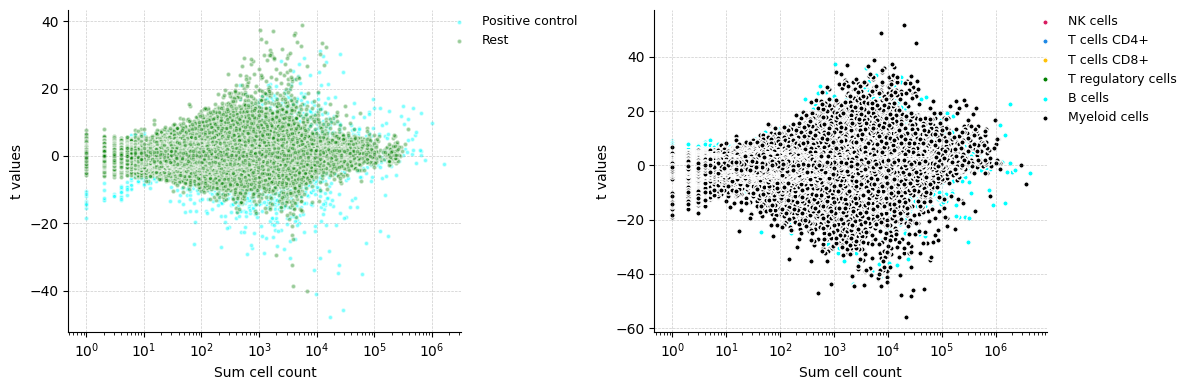

EdgeR
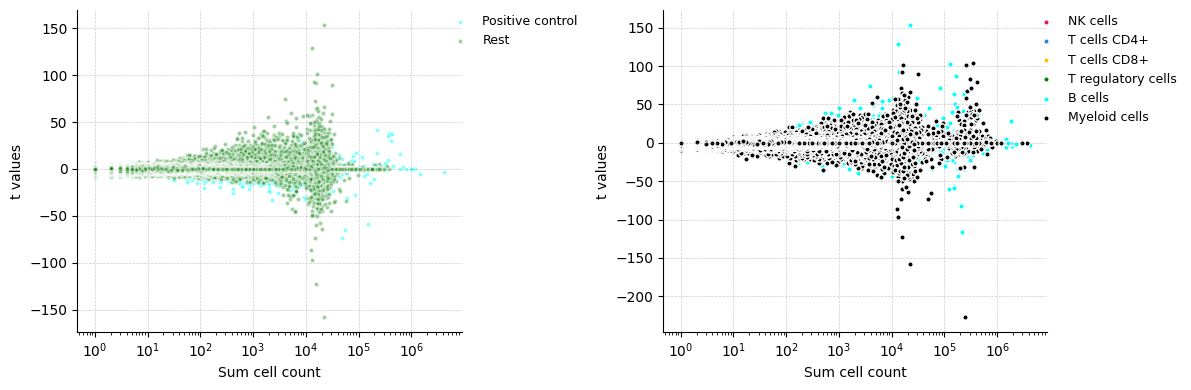

## <a id='toc8_1_'></a>[Normality of the distribution](#toc0_)

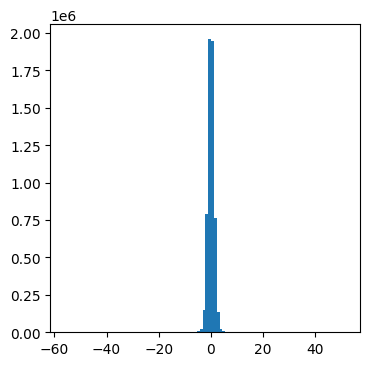

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=False)
data = de_train_t.values
aa = ax.hist(data.reshape(-1,1), bins=100)

## Variance 

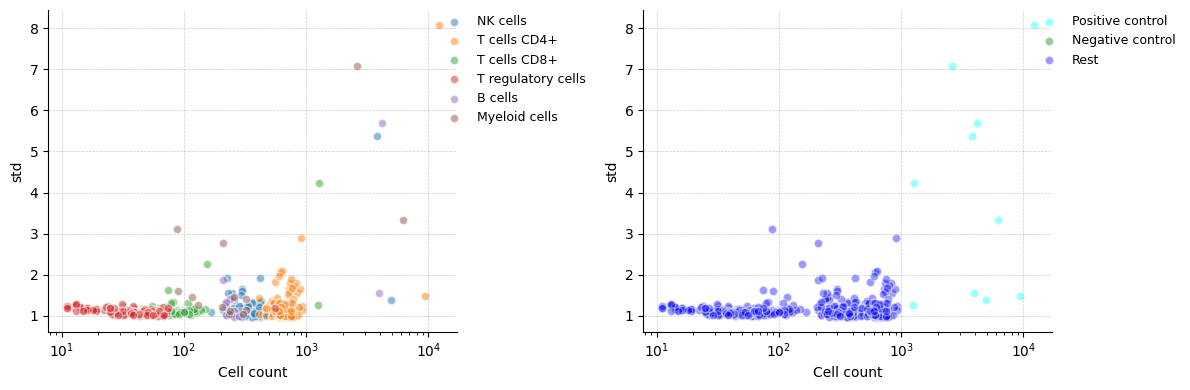

In [ ]:
xs = cell_count
ys = std

plot_scatter(de_train_t, obs_index, xs, ys, x_label='Cell count', y_label='std', log=True)

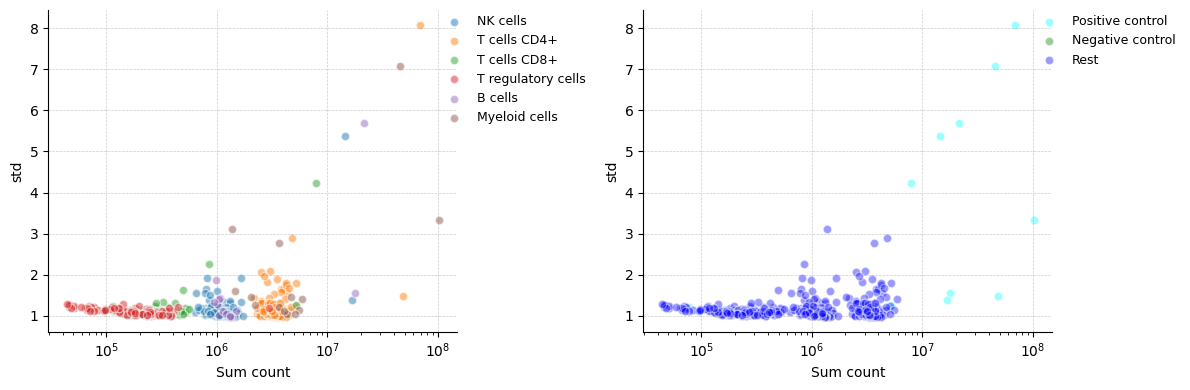

In [ ]:
xs = sum_count
ys = std

plot_scatter(de_train_t, obs_index, xs, ys, x_label='Sum count', y_label='std', log=True)

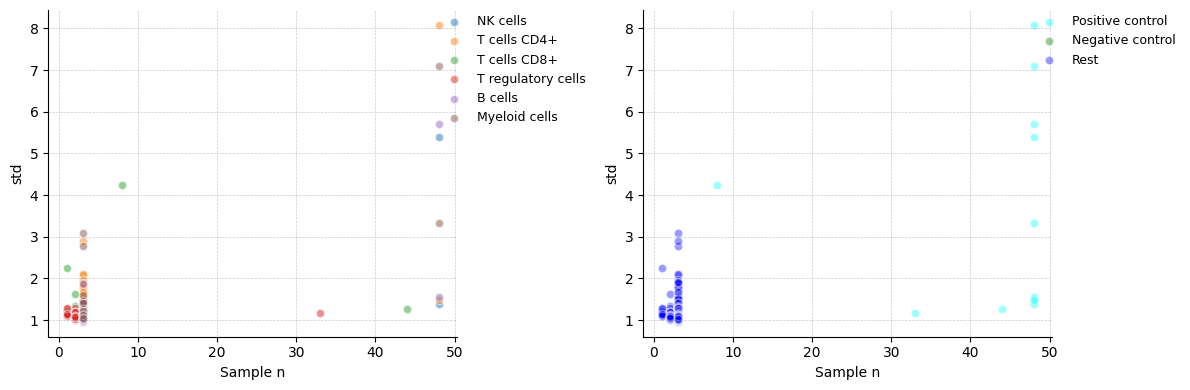

In [ ]:
xs = sample_n
ys = std

plot_scatter(de_train_t, obs_index, xs, ys, x_label='Sample n', y_label='std', log=False)

## Positive values

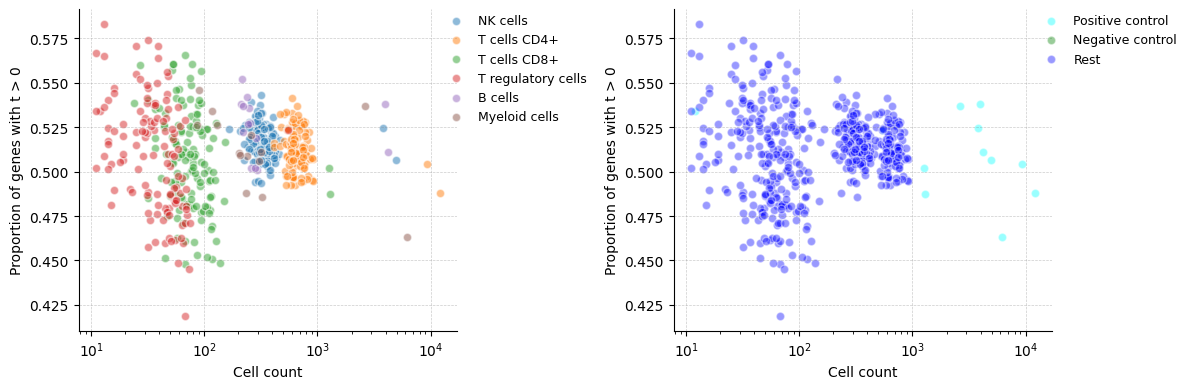

In [ ]:
xs = cell_count
ys = plus_values

plot_scatter(de_train_t, obs_index, xs, ys, x_label='Cell count', y_label='Proportion of genes with t > 0', log=True)

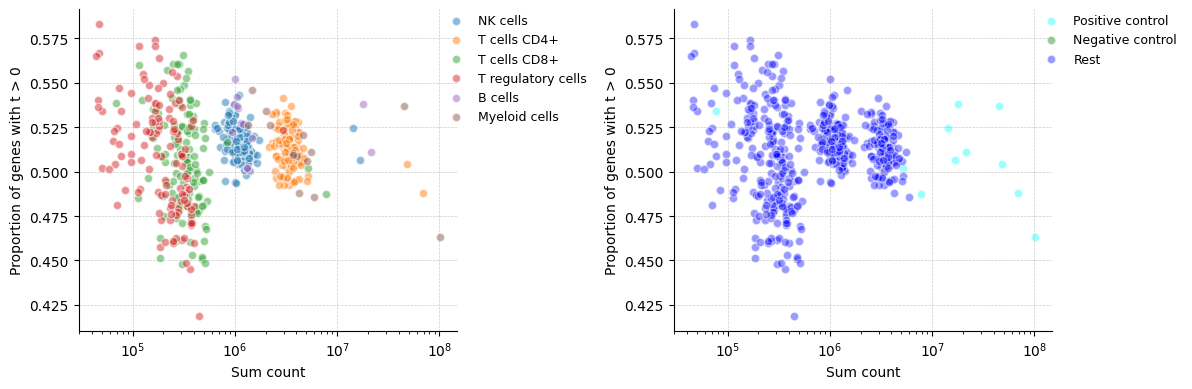

In [ ]:
xs = sum_count
ys = plus_values

plot_scatter(de_train_t, obs_index, xs, ys, x_label='Sum count', y_label='Proportion of genes with t > 0', log=True)

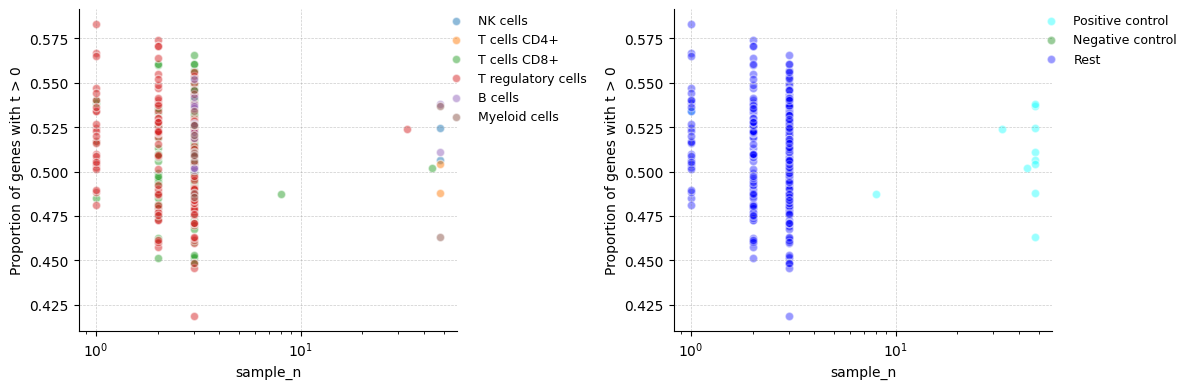

In [ ]:
xs = sample_n
ys = plus_values

plot_scatter(de_train_t, obs_index, xs, ys, x_label='sample_n', y_label='Proportion of genes with t > 0', log=True)

## Fraction of sig genes

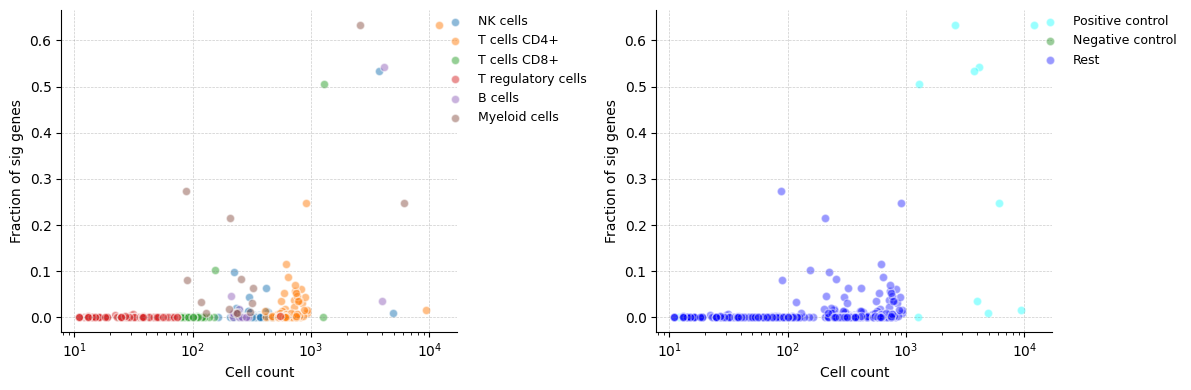

In [ ]:
xs = cell_count
ys = sig_values

plot_scatter(de_train_t, obs_index, xs, ys, x_label='Cell count', y_label='Fraction of sig genes', log=True)

## <a id='toc8_4_'></a>[Distribution of cell type classification](#toc0_)

## <a id='toc8_5_'></a>[Clusters: de-train vs raw expression](#toc0_)

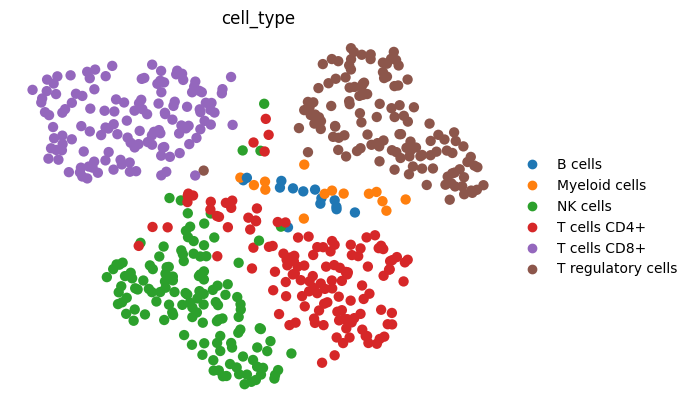

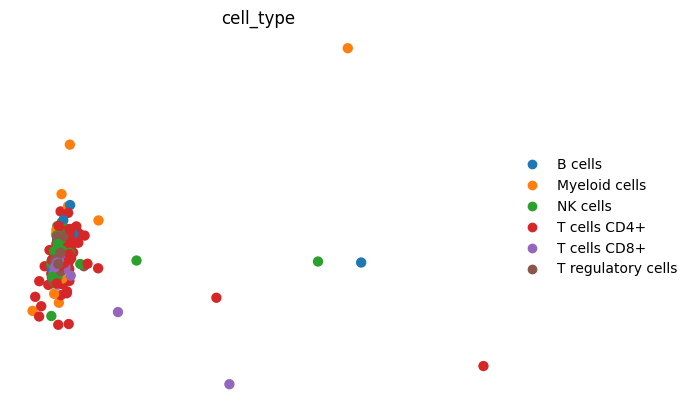

In [ ]:
df = de_train_t
obs=df.index.to_frame().reset_index(drop=True)
var=pd.DataFrame(index=df.columns)
adata = ad.AnnData(X=df.values, obs=obs , var=var)
with warnings.catch_warnings():
    # custom_normalize(adata)
    # sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata)
    sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['cell_type'], frameon=False)
    sc.pl.pca(adata, color=['cell_type'], frameon=False)

## <a id='toc8_6_'></a>[Top compounds](#toc0_)